In [1]:
import glob
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import segmentation_models as sm
import functools as ft

sm.set_framework('tf.keras')
sm.framework()

tf.random.set_seed(1024)
SEED = 100

Segmentation Models: using `keras` framework.


In [2]:
def get_image_decode(image, label):
    image = tf.io.read_file(image, "image")
    label = tf.io.read_file(label, "label")

    image = tf.image.decode_image(image)
    label = tf.image.decode_image(label)

    return image, label


# [w, h, c]
def decode_crop(image, label):
    image = image[256 // 2 : -(256 // 2), 368 // 2 : -(368 // 2)]
    label = label[256 // 2 : -(256 // 2), 368 // 2 : -(368 // 2)]

    img_array = []
    label_array = []

    for index in range(8 * 4):
        x, y = index // 8, index % 4
        img_array.append(image[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])
        label_array.append(label[448 * x : 448 * (1 + x), 448 * y : 448 * (1 + y)])

    return tf.data.Dataset.from_tensor_slices((img_array, label_array))


def get_mask(image, label):
    labels = []
    labels.append((label[:, :, 0] == 0) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0))
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 0) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 64) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 0) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 128) & (label[:, :, 1] == 128) & (label[:, :, 2] == 0)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 0) & (label[:, :, 2] == 128)
    )
    labels.append(
        (label[:, :, 0] == 192) & (label[:, :, 1] == 0) & (label[:, :, 2] == 192)
    )
    labels.append(
        (label[:, :, 0] == 64) & (label[:, :, 1] == 64) & (label[:, :, 2] == 0)
    )
    labels = tf.cast(labels, tf.float32)
    image = tf.cast(image, tf.float32)

    # must perform this
    return image, tf.transpose(labels, [1, 2, 0])


def create_ds(batch_size, istrain=True, maximage=False):
    AUTOTUNE = tf.data.AUTOTUNE

    if istrain:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_train/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)
    else:
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Images/*.png"
        images = glob.glob(directory, recursive=True)
        directory = "/home/hackerton/Downloads/uavid_v1.5_official_release/uavid_val/**/Labels/*.png"
        labels = glob.glob(directory, recursive=True)

    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.cache()
    if istrain:
        ds = ds.shuffle(6400, SEED, reshuffle_each_iteration=True)
    ds = ds.map(get_image_decode, AUTOTUNE)

    if not maximage:
        ds = ds.flat_map(decode_crop)

    ds = ds.map(get_mask, AUTOTUNE)

    # batch and prefetch
    ds = ds.batch(batch_size)

    if istrain:
        ds = ds.prefetch(AUTOTUNE)

    return ds


In [3]:
def create_backbone():
    _backbone = tf.keras.applications.EfficientNetB0(
        include_top=False, input_shape=[None, None, 3]
    )

    outputs = [
        layer.output
        for layer in _backbone.layers
        if layer.name
        in [
            "block2a_activation",
            "block3a_activation",
            "block5a_activation",
            "block7a_activation",
        ]
    ]

    return tf.keras.Model(
        inputs=[_backbone.input], outputs=outputs, name="efficientb0_backbone"
    )


class FPN(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name="Feature_Pyramid_Network", **kwargs)

        self.backbone = create_backbone()
        self.conv5_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv4_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv3_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv2_1x1 = tf.keras.layers.Conv2D(
            filters=256, kernel_size=(1, 1), padding="same"
        )
        self.conv5_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv5_bn = tf.keras.layers.BatchNormalization()
        self.conv4_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv4_bn = tf.keras.layers.BatchNormalization()
        self.conv3_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv3_bn = tf.keras.layers.BatchNormalization()
        self.conv2_3x3_1 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_3x3_2 = tf.keras.layers.Conv2D(
            filters=128, kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.conv2_bn = tf.keras.layers.BatchNormalization()
        self.upscale = tf.keras.layers.UpSampling2D(size=(2, 2))

    def call(self, images, training=False):
        # 112x112, 56x56, 28x28, 14x14
        conv2, conv3, conv4, conv5 = self.backbone(images, training=training)
        conv5_m = self.conv5_1x1(conv5)
        conv5_p = self.conv5_3x3_1(conv5_m)
        conv5_p = self.conv5_3x3_2(conv5_p)
        conv5_p = self.conv5_bn(conv5_p, training=training)

        conv4_m_1 = self.upscale(conv5_m)
        conv4_m_2 = self.conv4_1x1(conv4)
        conv4_m = conv4_m_1 + conv4_m_2
        conv4_p = self.conv4_3x3_1(conv4_m)
        conv4_p = self.conv4_3x3_2(conv4_p)
        conv4_p = self.conv4_bn(conv4_p, training=training)

        conv3_m_1 = self.upscale(conv4_m)
        conv3_m_2 = self.conv3_1x1(conv3)
        conv3_m = conv3_m_1 + conv3_m_2
        conv3_p = self.conv3_3x3_1(conv3_m)
        conv3_p = self.conv3_3x3_2(conv3_p)
        conv3_p = self.conv3_bn(conv3_p, training=training)

        conv2_m_1 = self.upscale(conv3_m)
        conv2_m_2 = self.conv2_1x1(conv2)
        conv2_m = conv2_m_1 + conv2_m_2
        conv2_p = self.conv2_3x3_1(conv2_m)
        conv2_p = self.conv2_3x3_2(conv2_p)
        conv2_p = self.conv2_bn(conv2_p, training=training)
        return conv5_p, conv4_p, conv3_p, conv2_p


class FCN(tf.keras.Model):
    def __init__(self, n_classes=8, **kwargs):
        super().__init__(name="FCN", **kwargs)
        self.fpn = FPN()
        self.upscale_2x = tf.keras.layers.UpSampling2D()
        self.upscale_4x = tf.keras.layers.UpSampling2D((4, 4))
        self.upscale_8x = tf.keras.layers.UpSampling2D((8, 8))
        self.concat = tf.keras.layers.Concatenate()
        self.conv6 = tf.keras.layers.Conv2D(
            filters=(512), kernel_size=(3, 3), padding="same", activation="relu"
        )
        self.bnorm = tf.keras.layers.BatchNormalization()
        self.conv7 = tf.keras.layers.Conv2D(
            filters=n_classes, kernel_size=(1, 1), padding="same", activation="relu"
        )
        self.upscale_final = tf.keras.layers.UpSampling2D(
            size=(4, 4), interpolation="bilinear"
        )
        self.final_activation = tf.keras.layers.Activation("softmax")

    def set_trainable(self, state=False):
        for layer in self.fpn.backbone.layers:
            layer.trainable = state

    def call(self, images, training=False):
        conv5_p, conv4_p, conv3_p, conv2_p = self.fpn(images, training=training)
        m_5 = self.upscale_8x(conv5_p)
        m_4 = self.upscale_4x(conv4_p)
        m_3 = self.upscale_2x(conv3_p)
        m_2 = conv2_p

        m_all = self.concat([m_2, m_3, m_4, m_5])
        m_all = self.conv6(m_all)
        m_all = self.bnorm(m_all, training=training)
        m_all = self.conv7(m_all)
        m_all = self.upscale_final(m_all)
        m_all = self.final_activation(m_all)

        return m_all


In [4]:
# the network must OUTPUT in logits [-inf, inf]
def Jindex(target, pred):
    return (tf.reduce_sum(target * pred) + 100) / (
        tf.reduce_sum((target + pred) - (target * pred)) + 100
    )


# # I hypothesis from_logits is the cause of NaN
def loss_fn(target, sample, weight, alpha=1, beta=0.5):
    loss = alpha * tf.reduce_mean(
        tf.keras.losses.categorical_crossentropy(target, sample),
    )
    return loss + beta * (1 - Jindex(target, sample, weight))


In [5]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [6]:
# this iteration is calculated fom 160 iteration from
# paper
n_epoch = 20
n_classes = 8
ds = create_ds(1)
test = create_ds(1, False)
# model = FCN(8)
model = sm.Unet(backbone_name='efficientnetb0', encoder_weights='imagenet', encoder_freeze=False, activation='softmax', classes=8)
# model = sm.FPN(backbone_name='efficientnetb0', encoder_weights='imagenet', encoder_freeze=True, activation='softmax', classes=8)

In [7]:
# lr = 0.001 is good but spiky, next learning rate to test is 0.0005
optimizer = tf.keras.optimizers.Adam(0.00001)
dice_loss = sm.losses.CategoricalFocalLoss()
focal_loss = sm.losses.DiceLoss()


In [8]:
ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckptmg = tf.train.CheckpointManager(ckpt, 'new_unet', 5)
ckptmg.restore_or_initialize()

In [9]:
# normalize gradient for pretrained network
iteration = 0
for _ in range(n_epoch):
    total_loss = 0
    total_num = 0
    total_iou = 0
    for bs_images, bs_labels in ds:
        # REMEMBER HERE
        bs_images = sm.get_preprocessing('efficientnetb0')(bs_images)

        with tf.GradientTape() as t:
            output = model(bs_images)
            c_loss = dice_loss(bs_labels, output) + 0.5 * focal_loss(bs_labels, output)

        total_num += 1
        total_loss += c_loss.numpy()
        total_iou += sm.metrics.iou_score(bs_labels, output)
        iteration += 1


        grad = t.gradient(c_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grad, model.trainable_variables))

        with train_summary_writer.as_default():
            tf.summary.scalar("iou", total_iou / total_num, step=iteration)
            tf.summary.scalar("loss", total_loss / total_num, step=iteration)


    total_iou_test = 0
    total_loss_test = 0
    total_num_test = 0
    for bs_images, bs_labels in test:
        output = model(bs_images, training=False)

        total_num_test += 1
        total_loss_test += dice_loss(bs_labels, output) + 0.5 * focal_loss(
            bs_labels, output
        )
        total_iou_test += sm.metrics.iou_score(bs_labels, output)

    with test_summary_writer.as_default():
        tf.summary.scalar("iou", total_iou_test / total_num_test, step=iteration)
        tf.summary.scalar("loss", total_loss_test / total_num_test, step=iteration)

    ckptmg.save()


0.41889965534210205


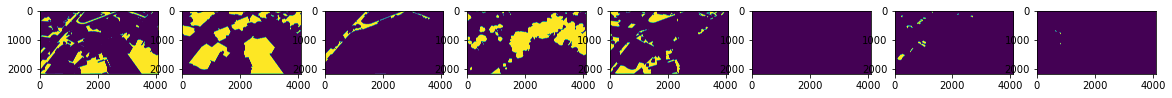

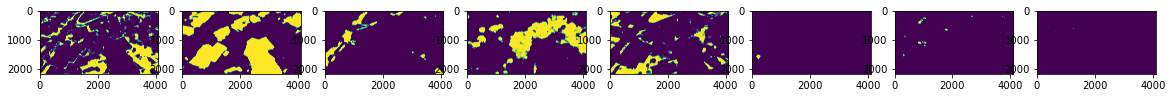

In [9]:
num = 0
total_iou = 0

test = create_ds(1, False, True)

for d, y in test.take(1):
    out_img = model(tf.pad(d, [[0, 0], [8, 8], [0, 0], [0,0]]), training=False)
    y = tf.pad(y, [[0, 0], [8, 8], [0, 0], [0,0]])

    fig, axs = plt.subplots(1, 8, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(y[0, :, :, i])

    fig, axs = plt.subplots(1, 8, figsize=(20, 20))
    for i, ax in enumerate(axs.flat):
        ax.imshow(out_img[0, :, :, i])

    num += 1
    total_iou += sm.metrics.iou_score(y, out_img).numpy()

print(total_iou / num)

In [12]:
def to_save(images, name):
    for idx in range(images[0].shape[-1]):
        byte = tf.image.encode_jpeg(tf.image.convert_image_dtype(images[0, ..., idx][..., tf.newaxis], tf.uint8))
        tf.io.write_file(f'{name}_{idx}_image.jpeg', byte)

to_save(out_img, 'target')
to_save(y, 'target')